# Bayesian Neural Network Calibration on a Toy Dataset

This notebook demonstrates **calibration** and **predictive uncertainty quantification** using a simple 2D toy dataset with overlapping Gaussian distributions. We compare five uncertainty quantification methods:

- **FNN**: Traditional feedforward network (deterministic baseline)
- **DropoutFNN**: FNN with Monte Carlo Dropout for uncertainty estimation
- **BayesianFNN**: Bayesian FNN using variational inference (Bayes by Backprop)
- **LaplaceFNN**: Post-hoc Laplace approximation on trained FNN
- **MCMCFNN**: MCMC sampling (NUTS) for exact Bayesian inference

## Objectives

1. **Compare calibration performance** across different uncertainty quantification methods
2. **Visualize predictive posteriors** and decision boundaries
3. **Analyze uncertainty estimates** using entropy-based metrics
4. **Validate against analytical Bayes optimal boundary** for ground truth comparison

This analysis provides insights into how different approaches to uncertainty quantification affect model calibration and predictive reliability.



In [1]:
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from bayescal.evaluation import calibration
from bayescal.models import FNN, MCMCFNN, BayesianFNN, DropoutFNN, LaplaceFNN
from bayescal.utils.model_export import export_model
from bayescal.utils.toy_dataset import generate_concentric_rings_dataset
from bayescal.utils.toy_training import evaluate_model, train_model
from bayescal.utils.toy_visualization import (
    plot_calibration_curves_comparison,
    plot_predictive_posterior,
    plot_uncertainty,
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Create figures directory for saving plots (relative to notebook location)
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)
print(f"Figures will be saved to: {figures_dir.absolute()}")

# Create model directory for saving exported models
save_model_directory = Path("models")
save_model_directory.mkdir(exist_ok=True)
print(f"Models will be saved to: {save_model_directory.absolute()}")

# Set random seed for reproducibility
seed = 42
NUM_CAL_BINS = 50
rng = jax.random.PRNGKey(seed)
np.random.seed(seed)

print("Imports complete!")

Figures will be saved to: /Users/kamilkrukowski/Code/BayesNNBench/notebooks/figures
Models will be saved to: /Users/kamilkrukowski/Code/BayesNNBench/notebooks/models
Imports complete!


## 1. Dataset Generation

We generate a synthetic 2D binary classification dataset with two overlapping Gaussian distributions:

- **Class 0**: Centered at $(-1, -1)$ with covariance matrix $\mathbf{I}$
- **Class 1**: Centered at $(1, 1)$ with covariance matrix $(1 + \text{overlap}) \cdot \mathbf{I}$

The `overlap` parameter controls the difficulty of the classification task. Higher overlap values create more ambiguous decision regions, making calibration assessment more meaningful.

**Filtering High-Confidence Regions**: We filter out points in regions with very high or very low class probability (P(class=1) < 0.05 or > 0.95). This keeps only ambiguous regions where calibration assessment is most meaningful, as models should be uncertain in these areas.

This controlled setting allows us to:
- **Visualize decision boundaries** in 2D space
- **Compare against analytical Bayes optimal boundary** (computed from the true data-generating distributions)
- **Assess calibration** in regions of high uncertainty



## 2. Concentric Rings Probability Field

We generate a dataset using a **clean sinusoidal logit field** over 2D space with **regular concentric rings**:

- **Smooth probability field**: p(x) = σ(A·sin(ω·r)) where r is the radial distance from center
- **Regular concentric rings**: Single-frequency sinusoid creates clean, evenly-spaced rings
- **Thin ring boundaries**: Sharp transitions between high/low probability regions
- **No angular variation**: Purely radial pattern for interpretability
- **Bounded probabilities**: All probabilities are capped between 0.05 and 0.95

This dataset provides a clean test case for calibration with well-defined decision boundaries at regular intervals.


Training set: 300 samples
Test set: 2700 samples


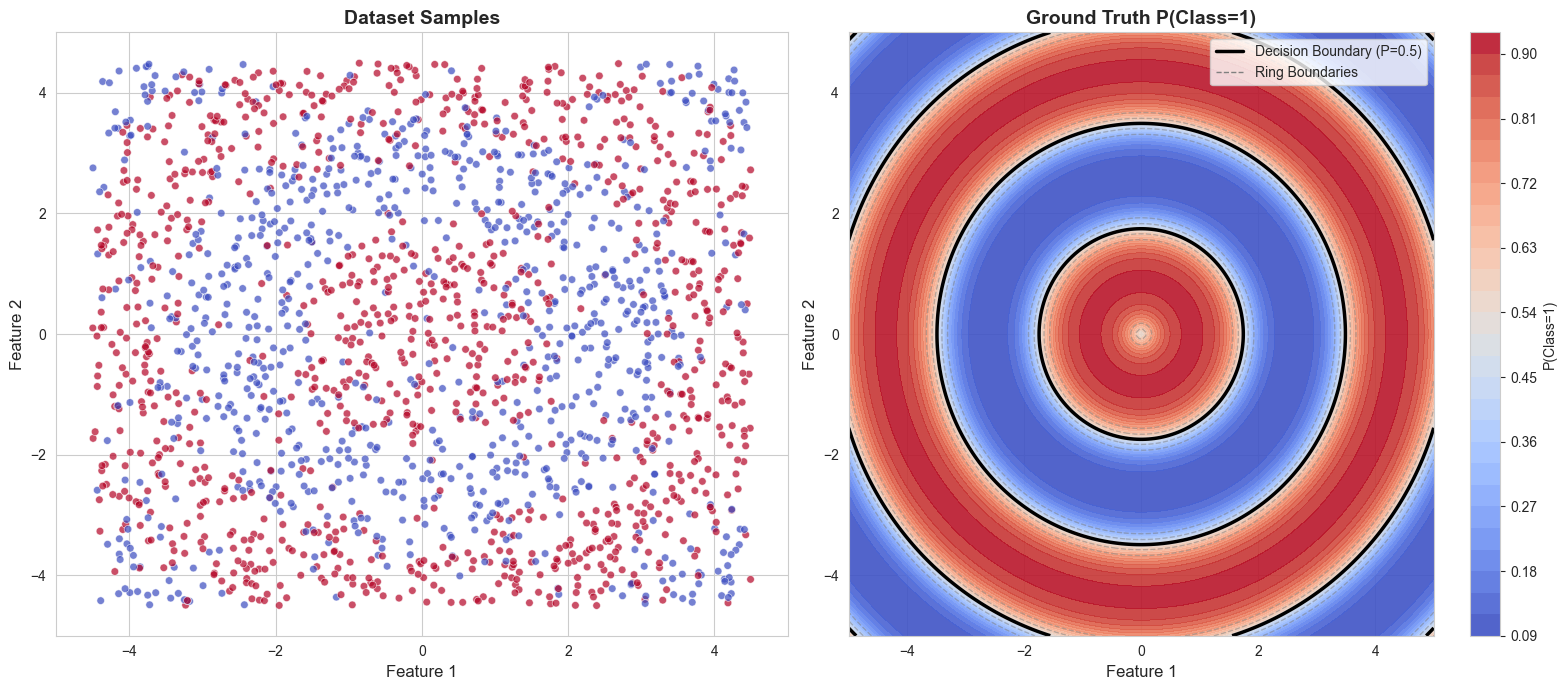

In [2]:
# Generate the concentric rings dataset (using the imported function from bayescal.utils.toy_dataset)
X_RANGE = (-5.0, 5.0)
Y_RANGE = (-5.0, 5.0)

X_grad, y_grad, y_grad_onehot, prob_func_grad = generate_concentric_rings_dataset(
    n_samples=3000,
    x_range=X_RANGE,
    y_range=Y_RANGE,
    min_prob=0.05,
    max_prob=0.95,
    seed=seed,
)

# Split into train/test
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
    X_grad, y_grad, y_grad_onehot, test_size=0.9, random_state=seed, stratify=y_grad
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================================
# Visualize: Dataset Scatter (left) + Ground Truth Probability Field (right)
# ============================================================================
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Left pane: Dataset scatter plot ---
ax_scatter = axes[0]
n_plot_points = 2000
if len(X_grad) > n_plot_points:
    _, X_plot, _, y_plot = train_test_split(
        X_grad,
        y_grad,
        test_size=n_plot_points / len(X_grad),
        random_state=seed,
        stratify=y_grad,
    )
else:
    X_plot, y_plot = X_grad, y_grad

scatter = ax_scatter.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="white",
    linewidth=0.5,
    s=30,
)
ax_scatter.set_xlabel("Feature 1", fontsize=12)
ax_scatter.set_ylabel("Feature 2", fontsize=12)
ax_scatter.set_title("Dataset Samples", fontsize=14, fontweight="bold")
ax_scatter.set_xlim(X_RANGE)
ax_scatter.set_ylim(Y_RANGE)

# --- Right pane: Ground truth probability field ---
ax_prob = axes[1]
grid_resolution = 200
x_min, x_max = X_RANGE
y_min, y_max = Y_RANGE
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_resolution),
    np.linspace(y_min, y_max, grid_resolution),
)

# Compute ground truth probabilities on the grid
grid_points_flat = np.column_stack([xx.ravel(), yy.ravel()])
prob_flat = np.array([prob_func_grad(x, y) for x, y in grid_points_flat])
prob_grid = prob_flat.reshape(xx.shape)

contour = ax_prob.contourf(xx, yy, prob_grid, levels=30, cmap="coolwarm", alpha=0.9)
ax_prob.contour(
    xx, yy, prob_grid, levels=[0.5], colors="black", linewidths=2.5, linestyles="-"
)
ax_prob.contour(
    xx,
    yy,
    prob_grid,
    levels=[0.3, 0.4, 0.6, 0.7],
    colors="gray",
    linewidths=1,
    linestyles="--",
    alpha=0.5,
)

ax_prob.set_xlabel("Feature 1", fontsize=12)
ax_prob.set_ylabel("Feature 2", fontsize=12)
ax_prob.set_title("Ground Truth P(Class=1)", fontsize=14, fontweight="bold")
ax_prob.set_xlim(X_RANGE)
ax_prob.set_ylim(Y_RANGE)
plt.colorbar(contour, ax=ax_prob, label="P(Class=1)")

# Legend for probability field
boundary_line = Line2D(
    [0],
    [0],
    color="black",
    linewidth=2.5,
    linestyle="-",
    label="Decision Boundary (P=0.5)",
)
ring_line = Line2D(
    [0], [0], color="gray", linewidth=1, linestyle="--", label="Ring Boundaries"
)
ax_prob.legend(handles=[boundary_line, ring_line], loc="upper right", fontsize=10)

plt.tight_layout()
plt.savefig(
    figures_dir / "toy_dataset_and_ground_truth.png", dpi=150, bbox_inches="tight"
)
plt.show()

## 2. Train Models

We'll train/fit five uncertainty quantification approaches:

### Training-time Methods
- **FNN**: Traditional feedforward network (baseline)
- **DropoutFNN**: FNN with Monte Carlo Dropout
- **BayesianFNN**: Bayesian FNN with variational inference (Bayes by Backprop)

### Post-hoc Methods
- **LaplaceFNN**: Laplace approximation fitted on trained FNN (last-layer)
- **MCMCFNN**: MCMC sampling using NUTS for exact Bayesian inference



In [3]:
# Train FNN
print("Training FNN...")
fnn_model = FNN(hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.0)
fnn_params, fnn_history = train_model(
    fnn_model, "FNN", X_train, y_train_onehot, epochs=200, seed=seed
)

fnn_probs, fnn_labels, fnn_metrics, fnn_fop, fnn_mpv = evaluate_model(
    fnn_model,
    fnn_params,
    X_test,
    y_test_onehot,
    n_samples=1,
    model_name="FNN",
    seed=seed,
    num_bins=NUM_CAL_BINS,
)
print({k: round(v, 4) for k, v in fnn_metrics.items()})

# Export FNN (saves to fnn/params.flax and fnn/model.json)
export_model(
    fnn_model,
    fnn_params,
    input_shape=(2,),  # 2D input for toy dataset
    output_path=save_model_directory,
    model_name="FNN",
    seed=seed,
)

Training FNN...
FNN - Epoch 50/200: Loss=0.5404, Acc=0.7395
FNN - Epoch 100/200: Loss=0.4103, Acc=0.7881
FNN - Epoch 150/200: Loss=0.3533, Acc=0.8205
FNN - Epoch 200/200: Loss=0.3347, Acc=0.8281
{'accuracy': 0.6793, 'ece': 0.1655, 'mce': 0.2632, 'tce': 0.1655, 'ace': 0.1648, 'brier': 0.4682}


In [4]:
# Train DropoutFNN
print("\nTraining DropoutFNN...")
dropout_fnn_model = DropoutFNN(
    hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.2
)
dropout_fnn_params, dropout_fnn_history = train_model(
    dropout_fnn_model, "DropoutFNN", X_train, y_train_onehot, epochs=200, seed=seed
)

# Evaluate DropoutFNN (with MC Dropout)
(
    dropout_fnn_probs,
    dropout_fnn_labels,
    dropout_fnn_metrics,
    dropout_fnn_fop,
    dropout_fnn_mpv,
) = evaluate_model(
    dropout_fnn_model,
    dropout_fnn_params,
    X_test,
    y_test_onehot,
    n_samples=100,
    model_name="DropoutFNN (MC=100)",
    seed=seed,
    num_bins=NUM_CAL_BINS,
)
print({k: round(v, 4) for k, v in dropout_fnn_metrics.items()})

# Export DropoutFNN (saves to dropoutfnn/params.flax and dropoutfnn/model.json)
export_model(
    dropout_fnn_model,
    dropout_fnn_params,
    input_shape=(2,),  # 2D input for toy dataset
    output_path=save_model_directory,
    model_name="DropoutFNN",
    seed=seed,
)


Training DropoutFNN...
DropoutFNN - Epoch 50/200: Loss=0.6647, Acc=0.5526
DropoutFNN - Epoch 100/200: Loss=0.6222, Acc=0.6472
DropoutFNN - Epoch 150/200: Loss=0.5885, Acc=0.6787
DropoutFNN - Epoch 200/200: Loss=0.5838, Acc=0.6787
{'accuracy': 0.717, 'ece': 0.1282, 'mce': 0.248, 'tce': 0.1282, 'ace': 0.1351, 'brier': 0.4327}


In [5]:
# Train BayesianFNN
print("\nTraining BayesianFNN...")
# Match DropoutFNN architecture for fair comparison
# DropoutFNN uses (128, 32, 32) and handles the complexity well
# With low beta (0.0001), BayesianFNN should also handle it
# Increase posterior_std_init to allow more weight exploration (default is 0.1, hyperopt found 0.0115 for different dataset)
# Use low beta (0.0001) with warmup to help model learn complex patterns
# Warmup allows model to learn data first, then gradually applies KL penalty
# IMPORTANT: Cap sigma to prevent excessive noise (max_std=0.1)
# With low beta, there's no incentive to shrink variances, so we must cap them
bayesian_fnn_model = BayesianFNN(
    hidden_dims=(32, 32, 32),
    num_classes=2,
    beta=0.05,
    posterior_std_init=0.1,
    max_std=0.1,
)
bayesian_fnn_params, bayesian_fnn_history = train_model(
    bayesian_fnn_model,
    "BayesianFNN",
    X_train,
    y_train_onehot,
    epochs=400,  # More epochs needed for complex patterns
    lr=0.0015,  # Moderate LR
    seed=seed,
    warm_up_epochs=50,  # Warmup for first 500 epochs
)

# Evaluate BayesianFNN (with MC sampling)
(
    bayesian_fnn_probs,
    bayesian_fnn_labels,
    bayesian_fnn_metrics,
    bayesian_fnn_fop,
    bayesian_fnn_mpv,
) = evaluate_model(
    bayesian_fnn_model,
    bayesian_fnn_params,
    X_test,
    y_test_onehot,
    n_samples=100,
    model_name="BayesianFNN (MC=100)",
    seed=seed,
    num_bins=NUM_CAL_BINS,
)
print("\nTraining complete!")
print({k: round(v, 4) for k, v in bayesian_fnn_metrics.items()})

"""
# Export BayesianFNN (saves to bayesianfnn/params.flax and bayesianfnn/model.json)
export_model(
    bayesian_fnn_model,
    bayesian_fnn_params,
    input_shape=(2,),  # 2D input for toy dataset
    output_path=save_model_directory,
    model_name="BayesianFNN",
    seed=seed,
)
"""


Training BayesianFNN...
BayesianFNN - Epoch 50/400: Loss=1.3410, Acc=0.5097, Likelihood=0.6837, KL=3944, KL_norm=13.1463, β*KL_norm=0.6442 (warmup β=0.049000), σ_mean=0.1000, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 100/400: Loss=1.3256, Acc=0.5687, Likelihood=0.6683, KL=3944, KL_norm=13.1469, β*KL_norm=0.6573, σ_mean=0.1000, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 150/400: Loss=1.3218, Acc=0.5994, Likelihood=0.6644, KL=3944, KL_norm=13.1476, β*KL_norm=0.6574, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 200/400: Loss=1.3287, Acc=0.5926, Likelihood=0.6711, KL=3945, KL_norm=13.1515, β*KL_norm=0.6576, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 250/400: Loss=1.3119, Acc=0.6241, Likelihood=0.6542, KL=3946, KL_norm=13.1547, β*KL_norm=0.6577, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 300/400: Loss=1.3056, Acc=0.6054, Likelihood=0.6474, KL=3949, KL_norm=13.1646, β*KL_norm=0.6582, σ_mean=0.0998, σ_median=0.100

'\n# Export BayesianFNN (saves to bayesianfnn/params.flax and bayesianfnn/model.json)\nexport_model(\n    bayesian_fnn_model,\n    bayesian_fnn_params,\n    input_shape=(2,),  # 2D input for toy dataset\n    output_path=save_model_directory,\n    model_name="BayesianFNN",\n    seed=seed,\n)\n'

In [6]:
# Fit LaplaceFNN (post-hoc on trained FNN)
print("\nFitting LaplaceFNN (post-hoc Laplace approximation)...")

# LaplaceFNN uses the trained FNN as the MAP estimate
laplace_fnn_model = LaplaceFNN.fit(
    base_model=fnn_model,
    params=fnn_params,
    X_train=X_train,
    y_train=y_train_onehot,
    prior_precision=10.0,
    subset_size=1000,  # Use subset for faster Hessian computation
)

# Evaluate LaplaceFNN
rng_laplace = jax.random.PRNGKey(seed + 3)
X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test_onehot)

laplace_probs = laplace_fnn_model(X_test_jax, rng_laplace, n_samples=100)
laplace_predicted = jnp.argmax(laplace_probs, axis=-1)
laplace_true = jnp.argmax(y_test_jax, axis=-1)

laplace_fnn_metrics = {
    "accuracy": float((laplace_predicted == laplace_true).mean()),
    "ece": calibration.expected_calibration_error(
        laplace_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "mce": calibration.maximum_calibration_error(
        laplace_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "tce": calibration.top_label_calibration_error(
        laplace_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "ace": calibration.adaptive_calibration_error(
        laplace_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "brier": calibration.brier_score(laplace_probs, y_test_jax),
}
laplace_fnn_fop, laplace_fnn_mpv = calibration.calibration_curve(
    laplace_probs, y_test_jax, num_bins=NUM_CAL_BINS, prune_small_bins=False
)

print("LaplaceFNN fitted!")
print({k: round(v, 4) for k, v in laplace_fnn_metrics.items()})


Fitting LaplaceFNN (post-hoc Laplace approximation)...
LaplaceFNN fitted!
{'accuracy': 0.6519, 'ece': 0.0788, 'mce': 0.2305, 'tce': 0.0788, 'ace': 0.0832, 'brier': 0.4323}


In [7]:
# Fit MCMCFNN (exact Bayesian inference via NUTS)
# Note: MCMC is slow!
print("\nFitting MCMCFNN (NUTS sampling)...")
print(
    "Note: MCMC is computationally expensive. Using smaller network for demonstration."
)

mcmc_fnn_model = MCMCFNN.fit(
    hidden_dims=(32, 32, 32),  # Smaller network for faster MCMC
    num_classes=2,
    X_train=X_train,
    y_train=y_train_onehot,
    prior_std=0.1,
    temperature=0.05,
    num_warmup=50,  # Warmup/burnin samples
    num_samples=50,  # Posterior samples to collect
    sampler="nuts",
    seed=seed,
)

# Evaluate MCMCFNN
rng_mcmc = jax.random.PRNGKey(seed + 4)
mcmc_probs = mcmc_fnn_model(X_test_jax, rng=rng_mcmc, n_samples=100)
mcmc_predicted = jnp.argmax(mcmc_probs, axis=-1)
mcmc_true = jnp.argmax(y_test_jax, axis=-1)

mcmc_fnn_metrics = {
    "accuracy": float((mcmc_predicted == mcmc_true).mean()),
    "ece": calibration.expected_calibration_error(
        mcmc_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "mce": calibration.maximum_calibration_error(
        mcmc_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "tce": calibration.top_label_calibration_error(
        mcmc_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "ace": calibration.adaptive_calibration_error(
        mcmc_probs, y_test_jax, num_bins=NUM_CAL_BINS
    ),
    "brier": calibration.brier_score(mcmc_probs, y_test_jax),
}
mcmc_fnn_fop, mcmc_fnn_mpv = calibration.calibration_curve(
    mcmc_probs, y_test_jax, num_bins=NUM_CAL_BINS, prune_small_bins=False
)

print("\nMCMCFNN complete!")
print({k: round(v, 4) for k, v in mcmc_fnn_metrics.items()})


Fitting MCMCFNN (NUTS sampling)...
Note: MCMC is computationally expensive. Using smaller network for demonstration.
MCMCFNN: 2274 parameters to sample
Using cold posterior with temperature=0.05
Running NUTS sampling...
Sampling complete. Shape: (50, 2274)

MCMCFNN complete!
{'accuracy': 0.713, 'ece': 0.0798, 'mce': 0.216, 'tce': 0.0798, 'ace': 0.0978, 'brier': 0.4088}


In [8]:
results_df = pd.DataFrame(
    {
        "Model": [
            "FNN",
            "DropoutFNN (MC=100)",
            "BayesianFNN (MC=100)",
            "LaplaceFNN (MC=100)",
            "MCMCFNN (NUTS)",
        ],
        "Accuracy": [
            fnn_metrics["accuracy"],
            dropout_fnn_metrics["accuracy"],
            bayesian_fnn_metrics["accuracy"],
            laplace_fnn_metrics["accuracy"],
            mcmc_fnn_metrics["accuracy"],
        ],
        "ECE": [
            fnn_metrics["ece"],
            dropout_fnn_metrics["ece"],
            bayesian_fnn_metrics["ece"],
            laplace_fnn_metrics["ece"],
            mcmc_fnn_metrics["ece"],
        ],
        "MCE": [
            fnn_metrics["mce"],
            dropout_fnn_metrics["mce"],
            bayesian_fnn_metrics["mce"],
            laplace_fnn_metrics["mce"],
            mcmc_fnn_metrics["mce"],
        ],
        "Brier Score": [
            fnn_metrics["brier"],
            dropout_fnn_metrics["brier"],
            bayesian_fnn_metrics["brier"],
            laplace_fnn_metrics["brier"],
            mcmc_fnn_metrics["brier"],
        ],
    }
)
print("\n" + "=" * 80)
print("Model Evaluation Results")
print("=" * 80)
print(results_df.to_string(index=False, float_format="%.4f"))
print("=" * 80)


Model Evaluation Results
               Model  Accuracy    ECE    MCE  Brier Score
                 FNN    0.6793 0.1655 0.2632       0.4682
 DropoutFNN (MC=100)    0.7170 0.1282 0.2480       0.4327
BayesianFNN (MC=100)    0.7385 0.1072 0.1886       0.3913
 LaplaceFNN (MC=100)    0.6519 0.0788 0.2305       0.4323
      MCMCFNN (NUTS)    0.7130 0.0798 0.2160       0.4088


## 4. Calibration Analysis

**Calibration** measures how well a model's predicted probabilities match the true empirical frequencies. A well-calibrated model should predict $P(y=1 | \mathbf{x}) = 0.7$ for samples where the true positive rate is approximately 70%.

### Metrics

- **ECE (Expected Calibration Error)**: Average absolute difference between predicted probabilities and empirical frequencies across bins (weighted by bin size)
- **MCE (Maximum Calibration Error)**: Maximum calibration error across all bins (worst-case error)
- **TCE (Top-label Calibration Error)**: Similar to ECE but explicitly focuses on the top-label (most confident) prediction
- **ACE (Adaptive Calibration Error)**: Uses adaptive binning with equal numbers of samples per bin (quantile-based), more robust to imbalanced confidence distributions
- **Brier Score**: Mean squared error between predicted probabilities and true labels (lower is better)

The calibration curve plots the **fraction of positives** (empirical frequency) against the **mean predicted probability** for each confidence bin. A perfectly calibrated model lies on the diagonal line.



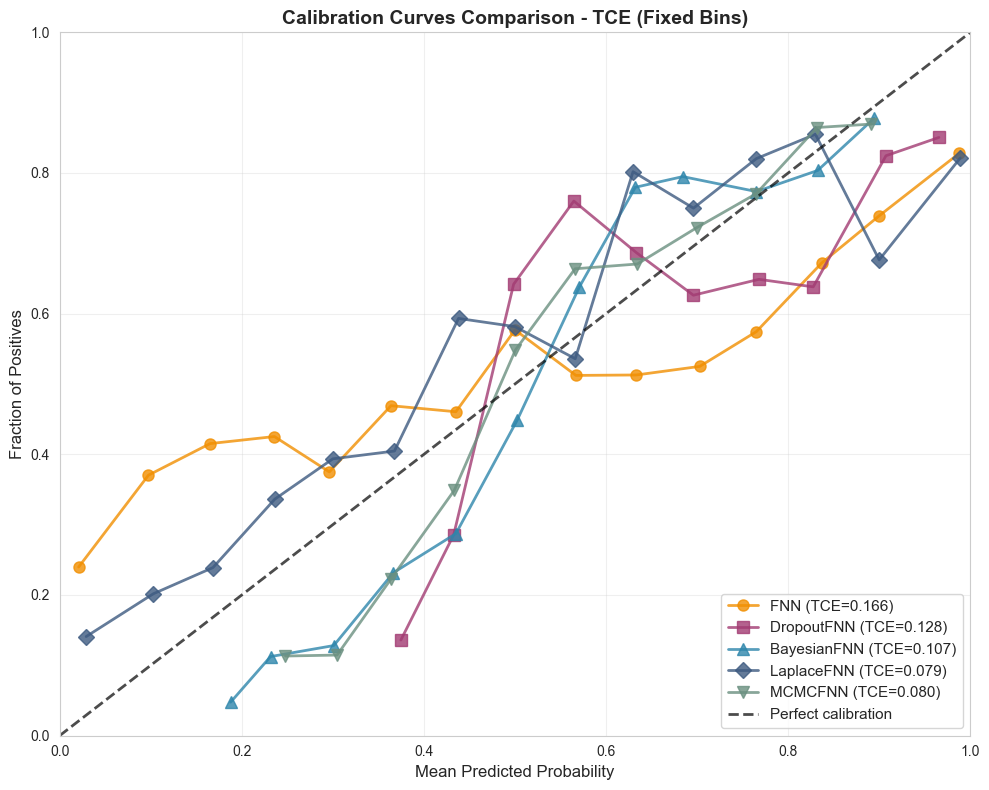

In [9]:
# Plot calibration curves comparison
# Pass predictions and labels so the function can compute curves with appropriate binning
# - 'ece' / 'tce': Fixed-width bins
# - 'ace': Adaptive bins (equal samples per bin)
plot_calibration_curves_comparison(
    [
        {
            "predictions": fnn_probs,
            "labels": fnn_labels,
            "ece": fnn_metrics["ece"],
            "ace": fnn_metrics["ace"],
            "tce": fnn_metrics["tce"],
            "label": "FNN",
            "color": "#F18F01",
            "marker": "o",
        },
        {
            "predictions": dropout_fnn_probs,
            "labels": dropout_fnn_labels,
            "ece": dropout_fnn_metrics["ece"],
            "ace": dropout_fnn_metrics["ace"],
            "tce": dropout_fnn_metrics["tce"],
            "label": "DropoutFNN",
            "color": "#A23B72",
            "marker": "s",
        },
        {
            "predictions": bayesian_fnn_probs,
            "labels": bayesian_fnn_labels,
            "ece": bayesian_fnn_metrics["ece"],
            "ace": bayesian_fnn_metrics["ace"],
            "tce": bayesian_fnn_metrics["tce"],
            "label": "BayesianFNN",
            "color": "#2E86AB",
            "marker": "^",
        },
        {
            "predictions": laplace_probs,
            "labels": y_test_jax,
            "ece": laplace_fnn_metrics["ece"],
            "ace": laplace_fnn_metrics["ace"],
            "tce": laplace_fnn_metrics["tce"],
            "label": "LaplaceFNN",
            "color": "#3D5A80",
            "marker": "D",
        },
        {
            "predictions": mcmc_probs,
            "labels": y_test_jax,
            "ece": mcmc_fnn_metrics["ece"],
            "ace": mcmc_fnn_metrics["ace"],
            "tce": mcmc_fnn_metrics["tce"],
            "label": "MCMCFNN",
            "color": "#6B9080",
            "marker": "v",
        },
    ],
    figures_dir=figures_dir,
    metric="tce",  # Options: 'ece', 'ace', 'tce', 'all'
    num_bins=15,
)

## 5. Predictive Posterior Visualization

We visualize the **predictive posterior distributions** $P(y=1 | \mathbf{x})$ across the input space. This allows us to:

1. **Inspect decision boundaries**: The black contour line shows where $P(y=1 | \mathbf{x}) = 0.5$ (the decision threshold)
2. **Assess probability contours**: The color gradient shows how confident the model is in different regions
3. **Compare to analytical boundary**: We can visually assess how well each model approximates the Bayes optimal boundary

For Bayesian models and DropoutFNN, we average predictions over multiple Monte Carlo samples to obtain more stable and calibrated probability estimates.



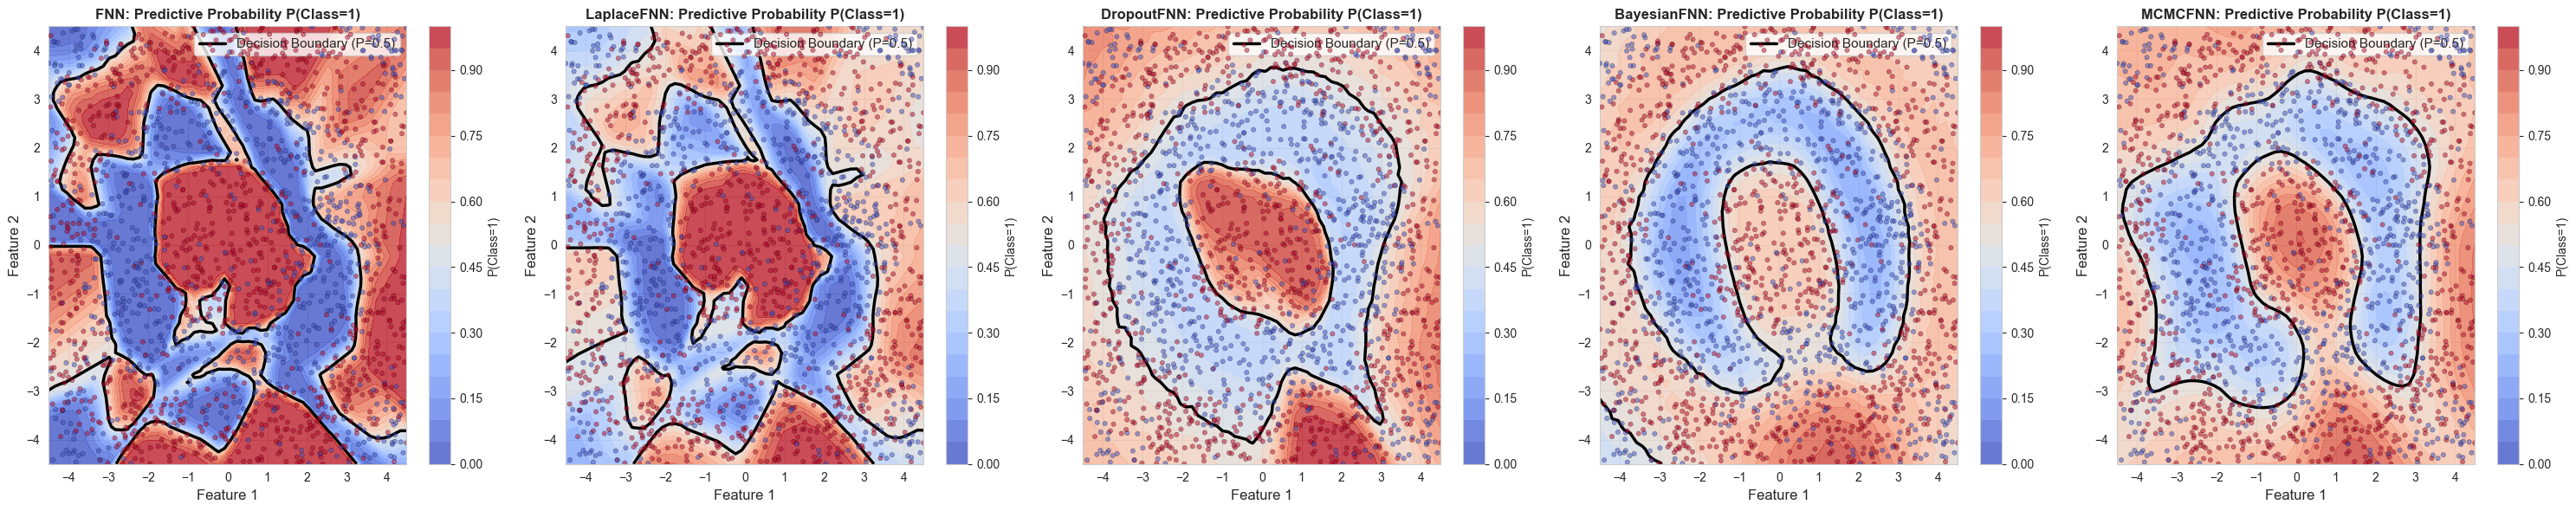

In [10]:
# Plot for each model using subplots (1 row, 5 cols)
fig, axes = plt.subplots(1, 5, figsize=(30, 6))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

# Fixed color scale for consistent comparison across all plots
VMIN, VMAX = 0.0, 1.0  # Full probability range


# Create a helper function with common parameters (X_test, y_test, seed, vmin, vmax)
def plot_posterior(model, params, name, n_samples, ax):
    """Helper function to plot predictive posterior with consistent color scale."""
    return plot_predictive_posterior(
        model,
        params,
        X_test,
        y_test,
        name,
        n_samples=n_samples,
        seed=seed,
        ax=ax,
        vmin=VMIN,
        vmax=VMAX,
    )


# Plot each model
plot_posterior(fnn_model, fnn_params, "FNN", 1, axes[0])
plot_posterior(dropout_fnn_model, dropout_fnn_params, "DropoutFNN", 512, axes[2])
plot_posterior(bayesian_fnn_model, bayesian_fnn_params, "BayesianFNN", 512, axes[3])
plot_posterior(
    laplace_fnn_model, {}, "LaplaceFNN", 256, axes[1]
)  # params ignored by LaplaceFNN
plot_posterior(mcmc_fnn_model, {}, "MCMCFNN", 256, axes[4])  # params ignored by MCMCFNN

plt.tight_layout()
if figures_dir:
    plt.savefig(
        figures_dir / "predictive_posterior_comparison.png",
        dpi=150,
        bbox_inches="tight",
    )
plt.show()

## 6. Uncertainty Quantification

We visualize **predictive uncertainty** using **entropy** as a measure:

$$H(\mathbf{x}) = -\sum_{c} P(y=c | \mathbf{x}) \log P(y=c | \mathbf{x})$$

Higher entropy indicates higher uncertainty. This visualization helps us understand:

- **Where models are uncertain**: Regions with high entropy (bright yellow/green) correspond to ambiguous decision regions
- **Uncertainty calibration**: Well-calibrated models should show high uncertainty near class boundaries and in regions with overlapping class distributions
- **Comparison across methods**: How different uncertainty quantification approaches (MC Dropout vs. Bayesian inference) differ in their uncertainty estimates

For models with Monte Carlo sampling, we compute entropy from the averaged predictive probabilities over multiple samples.



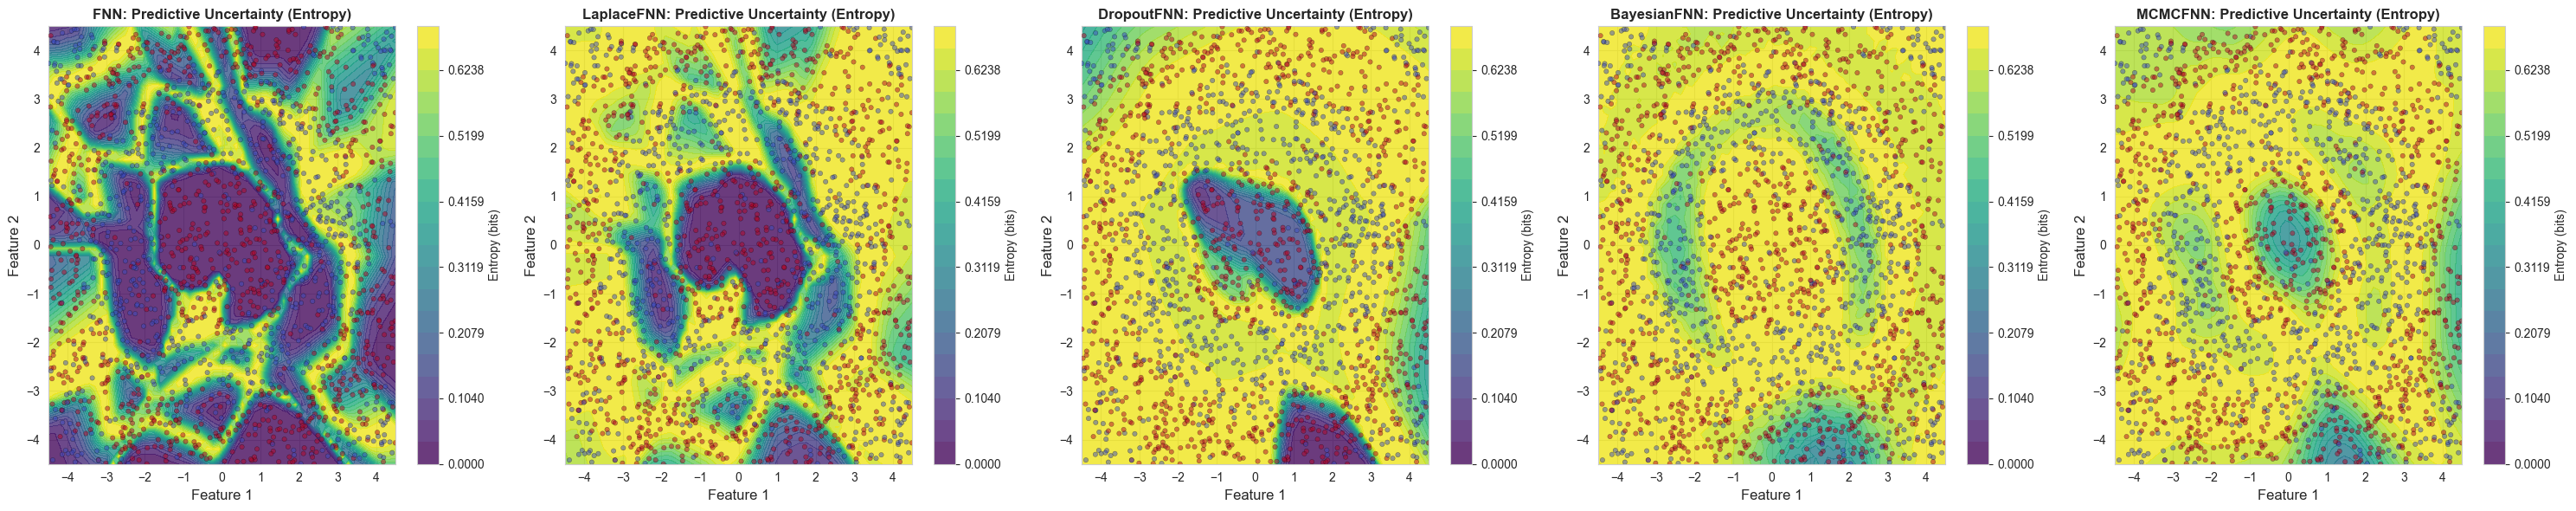

In [11]:
# Plot uncertainty (entropy) for all models using subplots (1 row, 5 cols)
fig, axes = plt.subplots(1, 5, figsize=(30, 6))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

# Fixed color scale for consistent comparison across all plots
# Max binary entropy is log(2) ≈ 0.693
ENTROPY_VMIN, ENTROPY_VMAX = 0.0, np.log(2)
USE_LOG_SCALE = (
    False  # Set to True for log-transformed colors (emphasizes low entropy regions)
)


# Create a helper function with common parameters (X_test, y_test, seed, vmin, vmax)
def plot_entropy(model, params, name, n_samples, ax):
    """Helper function to plot predictive uncertainty (entropy) with consistent color scale."""
    return plot_uncertainty(
        model,
        params,
        X_test,
        y_test,
        name,
        n_samples=n_samples,
        seed=seed,
        ax=ax,
        vmin=ENTROPY_VMIN,
        vmax=ENTROPY_VMAX,
        log_scale=USE_LOG_SCALE,
    )


# Plot each model
plot_entropy(fnn_model, fnn_params, "FNN", 1, axes[0])
plot_entropy(
    laplace_fnn_model, {}, "LaplaceFNN", 256, axes[1]
)  # params ignored by LaplaceFNN
plot_entropy(dropout_fnn_model, dropout_fnn_params, "DropoutFNN", 100, axes[2])
plot_entropy(bayesian_fnn_model, bayesian_fnn_params, "BayesianFNN", 100, axes[3])
plot_entropy(mcmc_fnn_model, {}, "MCMCFNN", 256, axes[4])  # params ignored by MCMCFNN

plt.tight_layout()
if figures_dir:
    plt.savefig(
        figures_dir / "uncertainty_entropy_comparison.png",
        dpi=150,
        bbox_inches="tight",
    )
plt.show()

## Summary

This notebook demonstrates five uncertainty quantification methods:

| Method | Type | Training | Inference |
|--------|------|----------|-----------|
| **FNN** | Deterministic | Standard SGD | Single forward pass |
| **DropoutFNN** | Approximate Bayesian | Standard SGD | MC Dropout sampling |
| **BayesianFNN** | Variational Inference | ELBO optimization | MC weight sampling |
| **LaplaceFNN** | Post-hoc Bayesian | MAP + Hessian | MC from Gaussian posterior |
| **MCMCFNN** | Exact Bayesian | NUTS sampling | Average over posterior samples |

### Key Observations

1. **Calibration**: Bayesian methods (VI, Laplace, MCMC) typically improve calibration over deterministic baselines
2. **Computational Trade-offs**:
   - MCMC provides asymptotically exact inference but is slow
   - Laplace is fast (post-hoc) but only captures last-layer uncertainty
   - VI (Bayes by Backprop) balances accuracy and speed
   - MC Dropout is simple but relies on heuristic uncertainty
3. **Uncertainty Quantification**: All Bayesian methods provide meaningful uncertainty estimates in ambiguous regions

